This is a notebook containing a mlp built from scratch

#Imports 

In [ ]:
import numpy as np
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import cv2
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

#Helper functions

In [ ]:
def print_missclassified_images(predictions, shape):
  misclassifiedIndexes = []
  index = 0
  for target, predict in zip(y_test, predictions):
    if target != predict:
      misclassifiedIndexes.append(index)
    index += 1

  plt.figure(figsize=(25,4))
  for index in range(5):
    plt.subplot(1,5,index+1)
    plt.imshow(X_test[misclassifiedIndexes[index]].reshape(shape), cmap='binary')
    plt.axis('off')
    plt.title(f'Target: {y_test[misclassifiedIndexes[index]]}    Predicted: {predictions[misclassifiedIndexes[index]]}', fontsize=14)

    plt.show()

def zero_list(size, position):
    array = []
    for j in range(size):
        array.append(0)
    array[position] = 1

    return array

def shuffle(features, targets):
    temp = list(zip(features, targets))
    random.shuffle(temp)
    shuffled_features, shuffled_targets = zip(*temp)

    return np.array(shuffled_features), np.array(shuffled_targets)

def decode_hot_vector(vector):
  temp_array = []
  for target in y_test:
    temp_array.append(np.argmax(target))

  return np.array(temp_array)

def one_hot_encode(targets):
    new_targets = []
    dictionary = encode_class(targets)
    for target in targets:
        new_targets.append(zero_list(len(dictionary), dictionary[target]))
    return np.array(new_targets)


def encode_class(labels):
    classes = np.unique(labels)

    label_dictionary = {}
    encoded_labels = []

    for i in range(len(classes)):
        label_dictionary[classes[i]] = i

    for i in range(len(labels)):
        encoded_labels.append(label_dictionary[labels[i]])
    print("Encoding: ",label_dictionary)

    return label_dictionary


# **MLP **

##class mlp

In [ ]:
# The Layer class is a class that contains the units, activation functions and their derivatives
class Layer:

    def __init__(self, units, activation=""):
        self.units = units
        self.activation = activation

    def activate(self, x, derivative=False):
        if self.activation == '' or self.activation is None:
            if derivative:
                return 1
            return x
        if self.activation.lower() == 'sigmoid':
            return self.sigmoid(x, derivative)
        elif self.activation.lower() == 'softmax':
            return self.softmax(x, derivative)
        elif self.activation.lower() == 'relu':
            return self.relu(x, derivative)
        elif self.activation.lower() == 'tanh':
            return self.tanh(x, derivative)

    def sigmoid(self, x, derivative=False):
        if derivative:
            # print("derivative of sig: ",(np.exp(-x)) / ((np.exp(-x) + 1) ** 2))
            return x * (1 - x)
            # (np.exp(-x)) / ((np.exp(-x) + 1) ** 2)
        return 1 / (1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponential
        if derivative:
            return x * (1 - x)
            # s = x.reshape(-1, 1)
            # return (np.diagflat(s) - np.dot(s, s.T))[0]
        exps = np.exp(x - x.max())
        return exps / np.sum(exps, axis=0)

    def relu(self, x, derivative=False):
        if derivative:
            return np.where(x <= 0, 0, 1)
        return np.maximum(0, x)

    def tanh(self, x, derivative=False):
        if derivative:
            return 1 - x ** 2
        return np.tanh(x)



# The class Bssf is initialized with a learning rate, weights, bias, and layers.
# It saves the best training model parameters
class Bssf:

    def __init__(self, learning_rate, weights, bias, layers):
        self.learning_rate = learning_rate
        self.weights = weights
        self.bias = bias
        self.layers = layers


# Multi Layer Perceptron class
# The class takes in the number of inputs, hidden layers, and outputs. It then initializes the weights
# and biases for each layer. It then computes the forward pass and backpropagation. It then updates
# the weights and biases using gradient descent

class mlp:

    def __init__(self, num_inputs=Layer(1), num_hidden=None,
                 num_outputs=Layer(1)):
        if num_hidden is None:
            num_hidden = []
        self.inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs
        self.activations = []
        self.weights = []
        self.derivatives = []
        self.bias = []
        self.bias_derivatives = []
        self.layers = []
        self.bssf = None
        self.best_accuracy = 0
        self.losses = []
        self.accuracies = []
        self.problem = 'c'
        self._compile()     # compiles model 

    def _compile(self):
        """
        We're initializing the weights and biases of each layer in the network
        """
   
        self.layers = [self.inputs] + self.num_hidden + [self.num_outputs]
        for i in range(len(self.layers) - 1):
            w = np.random.rand(self.layers[i].units, self.layers[i + 1].units) - 0.5
            b = np.zeros(self.layers[i + 1].units) - 0.5

            # delta weights & bias
            dw = np.random.rand(self.layers[i].units, self.layers[i + 1].units)
            db = np.zeros(self.layers[i + 1].units) - 0.5

            # print("Biases", b)
            self.weights.append(w)
            self.bias.append(b)
            self.derivatives.append(dw)
            self.bias_derivatives.append(db)

        for i in range(len(self.layers)):
            output = np.zeros(self.layers[i].units)
            self.activations.append(output)

        if self.num_outputs.units== 1 and self.num_outputs.activation == '':
          print("No activation in last layer")
          self.problem = 'r'
          self.best_accuracy = - np.inf

    def train(self, features, labels, epoch, learning_rate):
        # print(" feature: ", features, "Shape: ", features.shape)
        # print(" labels: ", labels, "Shape: ", labels.shape)
        # print()
        """
        The function takes in the features and labels, epochs, and learning rate. It shuffles the
        features and labels, then iterates through the features and labels. It then performs a forward
        pass, calculates the error, back propagates the error, performs gradient descent, and calculates
        the sum of squared errors. It then calculates the accuracy and loss, and appends them to the list
        of accuracies and errors. It then prints the epoch, loss, and accuracy. It then updates the best
        accuracy and best loss
        
        :param features: The input data
        :param labels: The labels of the data
        :param epoch: number of times to train the network
        :param learning_rate: The learning rate of the neural network
        :return: The best accuracy and the best loss.
        """
        for i in range(epoch):
            features, labels = shuffle(features, labels)

            sum_error = 0

            for feature, label in zip(features, labels):
                # print("Current feature: ", feature, "Shape: ", feature.shape)
                # print("Current labels: ", label, "Shape: ", label.shape)
                # print()

                outputs = self._forward_pass(feature)
                # print("Predicted:", outputs, "Target: ", label)
                # print("forward end ........ ")

                error = (outputs - label)  # predicted - target

                # print("Error", error, "Shape", error.shape)

                self._back_propagate(error)
                # print("Back prop end")

                self._gradient_descent(learning_rate)

                # sum training error 
                sum_error += self._se(label, outputs)

            
            loss = sum_error / len(features)
            self.losses.append(loss)
            accuracy = 1 - (sum_error / len(features))
            self.accuracies.append(accuracy)
           
            if self.problem != 'r' and self.problem != 'regression':  
              print("Epoch ", i, " MSE: ", loss, " Accuracy: ", accuracy)
            else:
               print("Epoch ", i, " MSE: ", loss)
            self._update_bssf(accuracy, learning_rate=learning_rate)

        print("\nDone Training")

        if self.problem == 'r':
          print("Best Loss: ", 1 - self.best_accuracy)
        else:
          print("Best Accuracy: ", self.best_accuracy, "Best Loss: ", 1 - self.best_accuracy)
        self.accuracies = np.array(self.accuracies)  
        self.losses = np.array(self.losses)
        return self.create_history(self.accuracies, self.losses)

    def evaluate(self, features, labels):
        """
        The function takes in a list of features and labels, and returns the accuracy and loss of the
        model
        
        :param features: the input data
        :param labels: The labels of the data
        :return: The accuracy and loss of the model.
        """
        return self.predict(features, labels)

    def predict(self, features, labels=None):
        """
        The function takes in a set of features and labels, and returns a set of predictions
        
        :param features: A dict of tensors representing the features in the batch
        :param labels: The labels of the data
        :return: The predictions of the model.
        """
        self.load_model()
        outputs = []
        sum_error = 0

        for i, feature in enumerate(features):
            output = self._forward_pass(feature)
            outputs.append(output)
            if labels is not None:
                sum_error += self._se(labels[i], output)

     
        # self.test_accuracy = accuracy
        # self.test_loss = loss

        if labels is not None:
          accuracy = 1 - (sum_error / len(features))
          loss = sum_error / len(features)
          if self.problem == 'r':
            return loss
          return accuracy, loss

        else:
            predictions = []
            for i in outputs:
                predictions.append(np.argmax(i))

        # returns max probability index, and probabilities for all labels
        return np.array(predictions), np.array(outputs)

    def _se(self, target, output):
        """
        The function takes in two parameters, target and output, and returns the average of the squared
        difference between the two
        
        :param target: the target values
        :param output: the output of the network
        :return: The average of the squared error.
        """
        return np.average((output - target) ** 2)

    def _forward_pass(self, features):
        """
        The function takes in the features and then iterates through the weights and bias and then
        returns the output
        
        :param features: The input data
        :return: The output of the input layer.
        """
        x = features
        self.activations[0] = features

        for i, w in enumerate(self.weights):
            net = np.dot(x, w) + self.bias[i]

            x = self.layers[i + 1].activate(net)
            # print("Weights", i, w, "Shape: ", w.shape)

            # print("Output", i + 1, x, "Shape", x.shape)
            self.activations[i + 1] = x
        return x

    def _back_propagate(self, error):
        """
        The function takes the error from the output layer and back propagates it through the network to
        calculate the derivatives of the weights and biases
        
        :param error: []
        """

        for i in reversed(range(len(self.weights))):
            activations = self.activations[i + 1]
            # print("activations", activations, "Shape", activations.shape)
            deriv_activation = self.layers[i + 1].activate(activations, derivative=True)
            delta = error * self.layers[i + 1].activate(activations, derivative=True)
            # print("delta", delta, "Shape", delta.shape)
            delta_reshaped = delta.reshape(delta.shape[0], -1).T
            # print("delta_reshaped", delta_reshaped, "Shape", delta_reshaped.shape)
            # print()
            previous_activations = self.activations[i]
            # print(" previous_activations", previous_activations, "Shape", previous_activations.shape)
            previous_activations_shaped = previous_activations.reshape(previous_activations.shape[0], -1)
            # print(" previous_activations_R", previous_activations_shaped, "Shape", previous_activations_shaped.shape)

            self.derivatives[i] = np.dot(previous_activations_shaped, delta_reshaped)
            self.bias_derivatives[i] = delta
            # print(" derivatives", self.derivatives[i], "Shape", self.derivatives[i].shape)
            # print()
            # print("Weights ", self.weights[i], "shape:", self.weights[i].shape)
            #
            # print("Weights T ", self.weights[i].T, "shape:", self.weights[i].T.shape)

            error = np.dot(delta, self.weights[i].T)

            # print("Error", error, "Shape", error.shape, "\n")
            # print()

    def _update_bssf(self, accuracy, learning_rate):
        """
        If the accuracy of the current model is better than the best accuracy so far, then update the
        best accuracy and the best model so far
        
        :param accuracy: the accuracy of the current model
        :param learning_rate: The learning rate of the neural network
        """
        if accuracy > self.best_accuracy:
            self.best_accuracy = accuracy
            self.bssf = Bssf(learning_rate=learning_rate, weights=self.weights, bias=self.bias, layers=self.layers)

    def _gradient_descent(self, learning_rate):
        """
        The function takes the learning rate as an argument and then subtracts the derivatives of the
        weights and biases from the weights and biases themselves
        
        :param learning_rate: The learning rate of the neural network
        """
        for i in range(len(self.weights)):
            self.weights[i] -= self.derivatives[i] * learning_rate
            self.bias[i] -= self.bias_derivatives[i] * learning_rate

    def create_history(self, train_accuracies, train_loss):
      train_accuracies = train_accuracies.reshape(1, -1).T
      # train_accuracies.reshape(1, -1).T
      train_loss = train_loss.reshape(1, -1).T
      history = np.append(train_accuracies, train_loss, 1)
      history = pd.DataFrame(history, columns=["Accuracy", "Loss"])
      return history

    def load_model(self):
        self.weights = self.bssf.weights
        self.bias = self.bssf.bias
        self.layers = self.bssf.layers

#Mnist Dataset

##Data Preprocessing

In [ ]:
mnist_digits = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist_digits.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
y_test[0]

7

In [ ]:
# 1. Preprocess data (both training and testing datasets)
# Scale to [0,1]
X_train_full = X_train_full/255
X_test = X_test/255

In [ ]:
# Reshape to 1D, or flatten, before sending to mlp
X_train_full = X_train_full.reshape(-1, 784) # -1 tells numpy to figure out size, would be 60000
X_test = X_test.reshape(-1, 784)  # -1 would be 10000

##*Training*

In [ ]:
#Model params 
model = mlp( 
                  Layer(784), #Input layer 
          
                 [ Layer(300, "relu"), # Hidden layers []
                 Layer(100, "relu"), 
                 Layer(50, "sigmoid")],
            
                 Layer(10, "softmax") # output layer
          )

In [ ]:
y_train_full = one_hot_encode(y_train_full)
y_test = one_hot_encode(y_test)


Encoding:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}
Encoding:  {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9}


In [ ]:
y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])

In [ ]:
model.train(X_train_full, y_train_full, 30, 0.01)

Epoch  0  MSE:  0.02789049335519373  Accuracy:  0.9721095066448062
Epoch  1  MSE:  0.012824372736253609  Accuracy:  0.9871756272637464
Epoch  2  MSE:  0.01005487558017656  Accuracy:  0.9899451244198234
Epoch  3  MSE:  0.008468669819787918  Accuracy:  0.9915313301802121
Epoch  4  MSE:  0.007312600817158787  Accuracy:  0.9926873991828412
Epoch  5  MSE:  0.0064125892813875  Accuracy:  0.9935874107186125
Epoch  6  MSE:  0.005706349159932767  Accuracy:  0.9942936508400673
Epoch  7  MSE:  0.005120981101806067  Accuracy:  0.994879018898194
Epoch  8  MSE:  0.004657124376355052  Accuracy:  0.995342875623645
Epoch  9  MSE:  0.004229093582151404  Accuracy:  0.9957709064178486
Epoch  10  MSE:  0.0038642664915713885  Accuracy:  0.9961357335084287
Epoch  11  MSE:  0.0035545674468173668  Accuracy:  0.9964454325531826
Epoch  12  MSE:  0.0032867995527457623  Accuracy:  0.9967132004472542
Epoch  13  MSE:  0.0029948144318652724  Accuracy:  0.9970051855681348
Epoch  14  MSE:  0.002784443642967627  Accurac

(0.9986962010321794, 0.001303798967820624)

In [ ]:
# evaluate test set 
model.evaluate(X_test, y_test) # output - accuracy, loss

(0.9946582618934366, 0.005341738106563395)

In [ ]:
import matplotlib.pyplot as plt
predictions = model.predict(X_test)

In [ ]:
# Take the argmax of the predicitions (argmax, probabilities)
predictions = predictions[0]
print(predictions)

[7 2 1 ... 4 5 6]


In [ ]:
#Convert one hot encoded y_test back to 1D
y_test = decode_hot_vector(y_test)

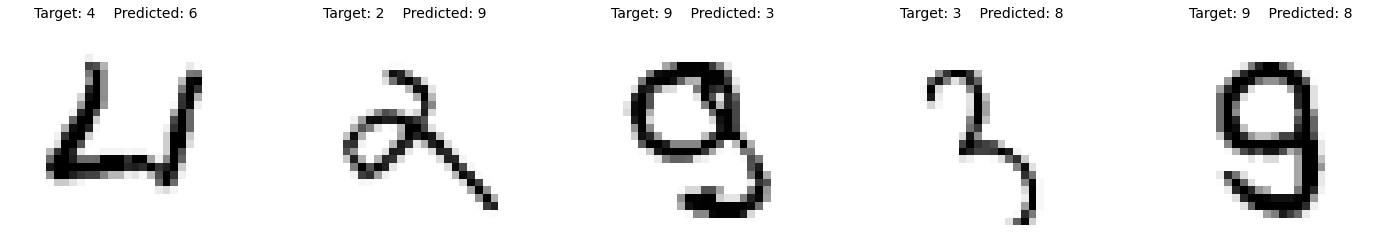

In [ ]:
# Print missclassified images 
  misclassifiedIndexes = []
  index = 0
  for target, predict in zip(y_test, predictions):
    if target != predict:
      misclassifiedIndexes.append(index)
    index += 1

  plt.figure(figsize=(25,4))
  for index in range(5):
    plt.subplot(1,5,index+1)
    plt.imshow(X_test[misclassifiedIndexes[index]].reshape(28,28), cmap='binary')
    plt.axis('off')
    plt.title(f'Target: {y_test[misclassifiedIndexes[index]]}    Predicted: {predictions[misclassifiedIndexes[index]]}', fontsize=14)

    plt.show()

In [ ]:
train_accuracies = model.accuracies
train_accuracies  = np.array(train_accuracies)

In [ ]:
train_loss = 1- train_accuracies
print(train_loss)

In [ ]:
# reshape 1D array to matrix
train_accuracies = train_accuracies.reshape(1, -1).T
train_accuracies.reshape(1, -1).T
train_loss = train_loss.reshape(1, -1).T

#Add columns
history = np.append(train_accuracies, train_loss, 1)
history

In [ ]:
history = pd.DataFrame(history, columns=["Accuracy", "Loss"])
history

,Accuracy,Loss
0,0.972110,0.027890
1,0.987176,0.012824
2,0.989945,0.010055
3,0.991531,0.008469
4,0.992687,0.007313
5,0.993587,0.006413
6,0.994294,0.005706
7,0.994879,0.005121
8,0.995343,0.004657
9,0.995771,0.004229


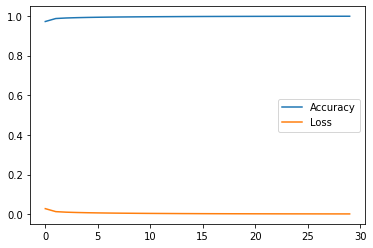

In [ ]:
history.plot()

In [ ]:
X_train_full.shape

#Cats vs Dogs

##Data Preprocessing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! unzip /content/sample_data/Cat_vs_dog_train.zip

Archive:  /content/sample_data/Cat_vs_dog_train.zip
replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace train/cat.1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/sample_data/Cat_vs_dog_test.zip
replace test/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
# Get labels 
import os

train_filenames = os.listdir("./train")
train_categories = []
for filename in train_filenames:
    category = filename.split('.')[0]
    if category == 'cat':
        train_categories.append(0)
    else:
        train_categories.append(1)

# create dataframe
df_train = pd.DataFrame({
    'filename': train_filenames,
    'category': train_categories
})

# test_filenames = os.listdir("./test")
# test_categories = []
# for filename in test_filenames:
#     category = filename.split('.')[0]
#     if category == 'cat':
#         train_categories.append(0)
#     else:
#         train_categories.append(1)

# # create dataframe
# df_test = pd.DataFrame({
#     'filename': test_filenames,
#     'category': test_categories
# })

In [ ]:
# resizing images
def resize_img(img):
  img = cv2.imread(img, cv2.IMREAD_COLOR)
  return cv2.resize(img, (60,60))  # This tuple represents the final image size desired

X_train = np.ndarray((25000,60,60,3)) # 25000 images, 60x60 pixels, 3 channels (RGB) 
for i,image_file in enumerate(df_train['filename']):
    X_train[i,:] = resize_img("./train/"+image_file)

In [ ]:
# X_test = np.ndarray((12500,60,60,3)) # 25000 images, 40x40 pixels, 3 channels (RGB) 
# for i,image_file in enumerate(df_test['filename']):
#     X_test[i,:] = resize_img("./train/"+image_file)

In [ ]:
temp = []
for i in range(len(X_train)):
  temp.append(X_train[i].flatten())


KeyboardInterrupt: ignored

In [ ]:

X_train = np.array(temp)
X_train.shape

(25000, 10800)

In [ ]:
X_train[0].shape

(10800,)

In [ ]:
X_train = X_train /255
X_train, X_test, y_train, y_test = train_test_split(X_train, train_categories,
                                                              test_size=5000)

##Training

In [ ]:
model = mlp(Layer(10800), [ Layer(500, "relu"),
                           Layer(500, "relu"), Layer(500, "relu"),
                           Layer(100, "sigmoid")

], Layer(1, "sigmoid"))

In [ ]:
model.train(X_train, y_train, 30, 0.01)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


Epoch  0  MSE:  0.2548148565772198  Accuracy:  0.7451851434227802
Epoch  1  MSE:  0.254230935203651  Accuracy:  0.7457690647963491
Epoch  2  MSE:  0.2542205597080661  Accuracy:  0.7457794402919339
Epoch  3  MSE:  0.2544271683861298  Accuracy:  0.7455728316138702
Epoch  4  MSE:  0.25427144920856387  Accuracy:  0.7457285507914362
Epoch  5  MSE:  0.25390442714184985  Accuracy:  0.7460955728581502
Epoch  6  MSE:  0.2540635815951313  Accuracy:  0.7459364184048687
Epoch  7  MSE:  0.2540024112301737  Accuracy:  0.7459975887698262
Epoch  8  MSE:  0.25415719041652246  Accuracy:  0.7458428095834775
Epoch  9  MSE:  0.25387490255214673  Accuracy:  0.7461250974478533


KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


(0.7494100035413251, 0.2505899964586749)

In [ ]:
predictions, probabilities = model.predict(X_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: overflow encountered in exp


In [ ]:
print_missclassified_images(predictions, (35,35,3))

TypeError: ignored

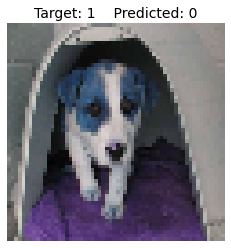

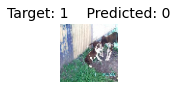

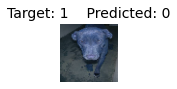

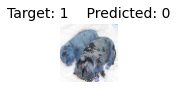

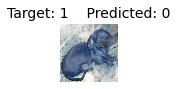

In [ ]:
misclassifiedIndexes = []
index = 0
for target, predict in zip(y_test, predictions):
  if target != predict:
    misclassifiedIndexes.append(index)
  index += 1

plt.figure(figsize=(25,4))
for index in range(5):
  plt.subplot(1,5,index+1)
  plt.imshow(X_test[misclassifiedIndexes[index]].reshape(60,60,3), cmap='binary')
  plt.axis('off')
  plt.title(f'Target: {y_test[misclassifiedIndexes[index]]}    Predicted: {predictions[misclassifiedIndexes[index]]}', fontsize=14)

  plt.show()

In [ ]:
model.accuracies = np.array(model.accuracies)
# history = model.create_history(model.accuracies, 1- model.accuracies)

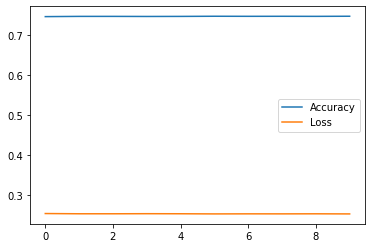

In [ ]:
history = model.create_history(model.accuracies, 1- model.accuracies)
history.plot()

In [ ]:
print(y_test[1], predictions[1])

0 0


# Iris 

##Data Processing

In [ ]:
iris = datasets.load_iris()
x = iris.data
y = iris.target

In [ ]:
x

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=20)

In [ ]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(120, 4) (30, 4) (120,) (30,)


In [ ]:
encoded_y_train = one_hot_encode(y_train)
encoded_y_test = one_hot_encode(y_test)

Encoding:  {0: 0, 1: 1, 2: 2}
Encoding:  {0: 0, 1: 1, 2: 2}


## *Training*

In [ ]:
model = mlp( Layer(4), #Input layer 
            
          [ Layer(8, "relu"), # Hidden layers []
            Layer(8, "relu")
          ],
            Layer(3, "softmax") # output layer
          )

In [ ]:
iris_history = model.train(x_train, encoded_y_train, 25, 0.01)

Epoch  0  MSE:  0.2355001696357308  Accuracy:  0.7644998303642692
Epoch  1  MSE:  0.21010973676749592  Accuracy:  0.7898902632325041
Epoch  2  MSE:  0.1977354761327702  Accuracy:  0.8022645238672298
Epoch  3  MSE:  0.18878794003284172  Accuracy:  0.8112120599671583
Epoch  4  MSE:  0.18021415271418445  Accuracy:  0.8197858472858155
Epoch  5  MSE:  0.172844517827712  Accuracy:  0.827155482172288
Epoch  6  MSE:  0.16335379723924917  Accuracy:  0.8366462027607509
Epoch  7  MSE:  0.15835227496254226  Accuracy:  0.8416477250374578
Epoch  8  MSE:  0.14798139192879753  Accuracy:  0.8520186080712024
Epoch  9  MSE:  0.13490772067092172  Accuracy:  0.8650922793290783
Epoch  10  MSE:  0.12080703012076591  Accuracy:  0.8791929698792341
Epoch  11  MSE:  0.11417465282661143  Accuracy:  0.8858253471733886
Epoch  12  MSE:  0.10362235473120583  Accuracy:  0.8963776452687942
Epoch  13  MSE:  0.09358192889013214  Accuracy:  0.9064180711098678
Epoch  14  MSE:  0.08763450472089121  Accuracy:  0.912365495279

In [ ]:
model.evaluate(x_test, encoded_y_test)

(0.9602537510193448, 0.03974624898065516)

In [ ]:
predictions, _ = model.predict(x_test)

In [ ]:
for predicted, target in zip(predictions, y_test):
  print("Predicted: ", predicted, " Target: ", target)

Predicted:  0  Target:  0
Predicted:  1  Target:  1
Predicted:  1  Target:  1
Predicted:  1  Target:  2
Predicted:  1  Target:  1
Predicted:  1  Target:  1
Predicted:  2  Target:  2
Predicted:  0  Target:  0
Predicted:  2  Target:  2
Predicted:  0  Target:  0
Predicted:  2  Target:  2
Predicted:  1  Target:  1
Predicted:  2  Target:  2
Predicted:  0  Target:  0
Predicted:  0  Target:  0
Predicted:  2  Target:  2
Predicted:  0  Target:  0
Predicted:  1  Target:  1
Predicted:  2  Target:  2
Predicted:  1  Target:  1
Predicted:  1  Target:  1
Predicted:  2  Target:  2
Predicted:  2  Target:  2
Predicted:  0  Target:  0
Predicted:  1  Target:  1
Predicted:  1  Target:  1
Predicted:  1  Target:  1
Predicted:  0  Target:  0
Predicted:  2  Target:  2
Predicted:  1  Target:  2


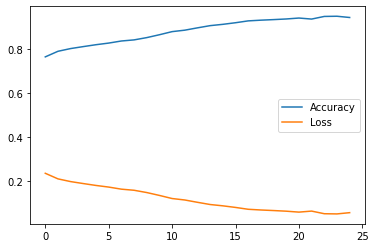

In [ ]:
iris_history.plot()

#Breast Cancer

## *Data*

In [ ]:
data = datasets.load_breast_cancer()
x= data.data
y = data.target
x

In [ ]:
scaler = MinMaxScaler().fit(x)
x = scaler.transform(x)

In [ ]:
print(x)

[[0.52103744 0.0226581  0.54598853 ... 0.91202749 0.59846245 0.41886396]
 [0.64314449 0.27257355 0.61578329 ... 0.63917526 0.23358959 0.22287813]
 [0.60149557 0.3902604  0.59574321 ... 0.83505155 0.40370589 0.21343303]
 ...
 [0.45525108 0.62123774 0.44578813 ... 0.48728522 0.12872068 0.1519087 ]
 [0.64456434 0.66351031 0.66553797 ... 0.91065292 0.49714173 0.45231536]
 [0.03686876 0.50152181 0.02853984 ... 0.         0.25744136 0.10068215]]


In [ ]:
x[0].shape

(30,)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2, random_state=20)

## *Training*

In [ ]:
model = mlp(Layer(30), [Layer(15, "relu")], Layer(1, "sigmoid"))

In [ ]:
history = model.train(x_train, y_train, 50, 0.01)

Epoch  0  MSE:  0.28966951282365616  Accuracy:  0.7103304871763438
Epoch  1  MSE:  0.25895280319100744  Accuracy:  0.7410471968089926
Epoch  2  MSE:  0.23227099570942092  Accuracy:  0.7677290042905791
Epoch  3  MSE:  0.20649656642806308  Accuracy:  0.7935034335719369
Epoch  4  MSE:  0.18411367958679653  Accuracy:  0.8158863204132034
Epoch  5  MSE:  0.16669237701819853  Accuracy:  0.8333076229818015
Epoch  6  MSE:  0.15241787322723052  Accuracy:  0.8475821267727695
Epoch  7  MSE:  0.14077000943325968  Accuracy:  0.8592299905667403
Epoch  8  MSE:  0.13095485769034224  Accuracy:  0.8690451423096578
Epoch  9  MSE:  0.12204172274405051  Accuracy:  0.8779582772559495
Epoch  10  MSE:  0.11506448248906041  Accuracy:  0.8849355175109396
Epoch  11  MSE:  0.1084102983091433  Accuracy:  0.8915897016908567
Epoch  12  MSE:  0.10288287581938575  Accuracy:  0.8971171241806143
Epoch  13  MSE:  0.09766021222438417  Accuracy:  0.9023397877756159
Epoch  14  MSE:  0.09343554325565699  Accuracy:  0.90656445

In [ ]:
model.evaluate(x_test, y_test)

(0.9683601608814434, 0.0316398391185566)

In [ ]:
predictions, prob = model.predict(x_test)

In [ ]:
for predicted, target in zip(prob, y_test):
  print("Predicted: ", predicted, " Target: ", target)

Predicted:  [0.9142357]  Target:  1
Predicted:  [0.62451463]  Target:  0
Predicted:  [0.00789281]  Target:  0
Predicted:  [0.85758606]  Target:  1
Predicted:  [0.23423264]  Target:  0
Predicted:  [0.00096133]  Target:  0
Predicted:  [0.02513509]  Target:  0
Predicted:  [0.90951238]  Target:  1
Predicted:  [0.89237037]  Target:  1
Predicted:  [7.17424622e-05]  Target:  0
Predicted:  [0.09140367]  Target:  0
Predicted:  [0.9142357]  Target:  1
Predicted:  [0.76118723]  Target:  1
Predicted:  [0.01633449]  Target:  0
Predicted:  [0.7297093]  Target:  1
Predicted:  [0.76339233]  Target:  1
Predicted:  [0.9142357]  Target:  1
Predicted:  [0.47163541]  Target:  0
Predicted:  [0.12873685]  Target:  0
Predicted:  [0.91533327]  Target:  1
Predicted:  [0.91055314]  Target:  1
Predicted:  [0.9142357]  Target:  1
Predicted:  [0.25988448]  Target:  0
Predicted:  [0.28103876]  Target:  0
Predicted:  [0.01251923]  Target:  0
Predicted:  [0.04144071]  Target:  0
Predicted:  [0.13679223]  Target:  0
Pr

In [ ]:
history

,Accuracy,Loss
0,0.727252,0.272748
1,0.760156,0.239844
2,0.786530,0.213470
3,0.808501,0.191499
4,0.827815,0.172185
5,0.844775,0.155225
6,0.859938,0.140062
7,0.873082,0.126918
8,0.884183,0.115817
9,0.893755,0.106245


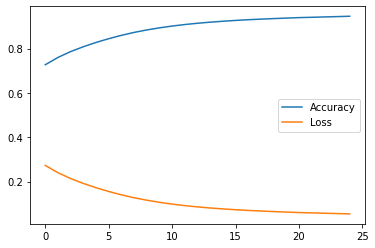

In [ ]:
history.plot()

# Boston Housing

In [ ]:
boston = tf.keras.datasets.boston_housing.load_data(path='boston_housing.npz',
                                                    test_split=0.2, seed=33)

In [ ]:
(x_train, y_train), ( x_test, y_test) = boston

In [ ]:
# normalize features 
scaler = MinMaxScaler()
fit = scaler.fit(x_train)
x_train = fit.transform(x_train)

scaler = MinMaxScaler()
fit = scaler.fit(x_test)
x_test = fit.transform(x_test)

In [ ]:
x_train[9]

array([0.00182871, 0.        , 0.92259259, 0.        , 0.40329218,
       0.4646484 , 0.88053553, 0.07850394, 0.04347826, 0.0019084 ,
       0.69148936, 0.97004388, 0.36092715])

In [ ]:
model = mlp(Layer(13), [ Layer(100, 'relu'), Layer(100, 'sigmoid')], Layer(1))

No activation in last layer


In [ ]:
history = model.train(x_train, y_train, 25, 0.01)

Epoch  0  MSE:  67.907271819275
Epoch  1  MSE:  41.51987448876924
Epoch  2  MSE:  32.03818670941042
Epoch  3  MSE:  31.64161946456862
Epoch  4  MSE:  28.26334550373113
Epoch  5  MSE:  24.82487994594221
Epoch  6  MSE:  22.78159503232501
Epoch  7  MSE:  22.989547741841776
Epoch  8  MSE:  22.42200134771661
Epoch  9  MSE:  20.24808224907062
Epoch  10  MSE:  20.803822069643743
Epoch  11  MSE:  18.418942336122498
Epoch  12  MSE:  17.666669991208966
Epoch  13  MSE:  20.15626366390914
Epoch  14  MSE:  19.007784412887435
Epoch  15  MSE:  17.111445818594824
Epoch  16  MSE:  16.63290124412064
Epoch  17  MSE:  18.411091136863597
Epoch  18  MSE:  18.211718936909776
Epoch  19  MSE:  18.249520208880174
Epoch  20  MSE:  21.493305351626724
Epoch  21  MSE:  17.484679694689316
Epoch  22  MSE:  21.964107090212327
Epoch  23  MSE:  18.361302521902083
Epoch  24  MSE:  17.83533803912499

  Done Training
Best Loss:  16.63290124412064


In [ ]:
model.evaluate(x_test, y_test)

15.37604539092622

In [ ]:
_, predicted = model.predict(x_test)

In [ ]:
for i in range(len(predicted)):
  print("predicted: ", predicted[i], " Target: ", y_test[i])

predicted:  [21.26634954]  Target:  18.6
predicted:  [25.33114107]  Target:  23.0
predicted:  [35.92734085]  Target:  42.3
predicted:  [11.48382279]  Target:  17.2
predicted:  [20.63722718]  Target:  16.2
predicted:  [21.26018227]  Target:  20.0
predicted:  [29.23016666]  Target:  30.3
predicted:  [22.39190272]  Target:  20.9
predicted:  [19.49254935]  Target:  20.4
predicted:  [25.57860601]  Target:  24.8
predicted:  [18.7696332]  Target:  18.7
predicted:  [19.41478944]  Target:  16.8
predicted:  [21.91955683]  Target:  22.5
predicted:  [19.08897523]  Target:  18.8
predicted:  [26.06643402]  Target:  23.7
predicted:  [23.17980553]  Target:  23.8
predicted:  [19.08587271]  Target:  19.6
predicted:  [21.21605965]  Target:  20.4
predicted:  [13.1889998]  Target:  16.1
predicted:  [34.55332688]  Target:  44.0
predicted:  [22.00211478]  Target:  19.3
predicted:  [19.56085759]  Target:  17.4
predicted:  [11.85341701]  Target:  10.2
predicted:  [13.11911743]  Target:  11.7
predicted:  [31.44

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

keras_model = Sequential()
keras_model.add(Dense(100, input_dim = 13, activation='relu'))
keras_model.add(Dense(100, activation='relu'))
keras_model.add(Dense(1))

In [ ]:
keras_model.compile(optimizer='sgd', loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])

In [ ]:
keras_model.fit(x_train, y_train, epochs=25, batch_size=32, 
                )

Epoch 1/25
13/13 [==============================] - 1s 2ms/step - loss: 440.3115 - root_mean_squared_error: 20.9836
Epoch 2/25
13/13 [==============================] - 0s 2ms/step - loss: 109.6919 - root_mean_squared_error: 10.4734
Epoch 3/25
13/13 [==============================] - 0s 2ms/step - loss: 63.4137 - root_mean_squared_error: 7.9633
Epoch 4/25
13/13 [==============================] - 0s 3ms/step - loss: 63.6702 - root_mean_squared_error: 7.9794
Epoch 5/25
13/13 [==============================] - 0s 2ms/step - loss: 72.0555 - root_mean_squared_error: 8.4885
Epoch 6/25
13/13 [==============================] - 0s 2ms/step - loss: 76.0307 - root_mean_squared_error: 8.7196
Epoch 7/25
13/13 [==============================] - 0s 2ms/step - loss: 61.4621 - root_mean_squared_error: 7.8398
Epoch 8/25
13/13 [==============================] - 0s 3ms/step - loss: 53.8634 - root_mean_squared_error: 7.3392
Epoch 9/25
13/13 [==============================] - 0s 2ms/step - loss: 54.6250 - ro